## Importing the Mashrooms Dataset

In [1]:
dataset = "mushrooms.txt" 
#the file must be in the same directory as notebook.

In [2]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

In [3]:
y = 2 * y - 3

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estimate Lipschitz constant L and lambda
w_initial = np.zeros(X_train.shape[1])  # Initial model parameters
L = np.sum(X_train**2)/(4 * (X_train.shape[0]))  # Estimate L
lambda_value = L / 1000  # Set lambda as a fraction of L

## Defining the Loss and Gradient

In [5]:
from scipy.special import expit
from functools import partial
import matplotlib.pyplot as plt
# Define logistic loss function
def logistic_loss(w, j, data_loader, lambda_reg = lambda_value):
    X, y = data_loader[j]
    logits = X.dot(w)
    loss = np.log(1 + np.exp(-y * logits)).mean()
    regularization_term = 0.5 * lambda_reg * np.sum(w**2)
    total_loss = loss + regularization_term
    return total_loss


# Define gradient of logistic loss
def logistic_loss_gradient(w, j, data_loader, lambda_reg = lambda_value):
    X, y = data_loader[j]
    n = len(y)
    logits = X.dot(w)
    sigmoid_values = expit(y * logits)
    gradient = -np.sum(X.T * (y * (1 - sigmoid_values) ), axis = 1) / n + lambda_reg * w
    return gradient

def batchify(x_arr, y_arr, b):
    
    # Calculate the number of batches
    num_batches = int(np.ceil(len(x_arr) / b))
    
    # Split the dataset into batches
    batches = [(x_arr[i*b:(i+1)*b], y_arr[i*b:(i+1)*b]) for i in range(num_batches)]
    
    return batches

data_loader = batchify(X_train, y_train, len(X_train)//12)
# Define the logistic loss function for logistic regression, partially applying the data loader to include batches.
f = partial(logistic_loss, data_loader=data_loader)

# Define the gradient of the logistic loss function, also partially applying the data loader.
nabla_f = partial(logistic_loss_gradient, data_loader=data_loader)

# Ru

## Quantization

In [6]:
from concurrent.futures import ThreadPoolExecutor
import time
from scipy import sparse 
import io
import time



def random_sparsify(gradient, sparsity_level):
    """
    Randomly sparsify the gradient to the desired sparsity level using scipy.sparse.coo_matrix.
    
    Args:
    - gradient (np.array): Original gradient.
    - sparsity_level (float): Fraction of elements to keep (e.g., 0.1 for 10%).

    Returns:
    - sparse_gradient (scipy.sparse.coo_matrix): Sparsified gradient.
    - indices (np.array): Indices of elements that are kept.
    """
    # Calculate the number of elements to keep
    num_elements = int(sparsity_level * len(gradient))
    # Randomly choose indices to keep
    indices = np.random.choice(len(gradient), num_elements, replace=False)
    # Create sparse gradient using coo_matrix also introducing unbiasedness
    sparse_gradient = sparse.coo_matrix(( (1/sparsity_level) * gradient[indices], (indices, np.zeros(num_elements))), shape=(len(gradient), 1))
    
    return sparse_gradient, indices

def compress_to_send(sparse_gradient):
    """
    Compress the sparsified gradient for transmission.
    
    Args:
    - sparse_gradient (scipy.sparse.coo_matrix): Sparsified gradient.

    Returns:
    - compressed_data (bytes): Compressed gradient data to send over the network.
    """
    # Use a buffer instead of a temporary file
    buffer = io.BytesIO()
    # Save the sparse matrix to the buffer
    sparse.save_npz(buffer, sparse_gradient, compressed=True)
    # Get the bytes from the buffer
    compressed_data = buffer.getvalue()
    
    return compressed_data

def decompress_to_receive(compressed_data, gradient_size):
    """
    Decompress the received gradient data.
    
    Args:
    - compressed_data (bytes): Compressed gradient data received over the network.
    - gradient_size (tuple): Shape of the original gradient.

    Returns:
    - decompressed_gradient (np.array): Decompressed gradient.
    """
    time.sleep(0.00001 * len(compressed_data))
    # Use a buffer instead of a temporary file
    buffer = io.BytesIO(compressed_data)
    # Load the sparse matrix from the buffer
    sparse_gradient = sparse.load_npz(buffer)
    # Convert the sparse matrix to a dense array
    decompressed_gradient = sparse_gradient.toarray().reshape(gradient_size)
    
    return decompressed_gradient

## Algorithm

In [7]:



n_workers = 12
x_0 = np.copy(w_initial)
h_i_0 = [np.copy(w_initial) for _ in range(n_workers)]
h_0 = np.mean(h_i_0, axis=0)
sparsity_level = 0.2 # percentatge of the gradient that is set to be nonzero
# Learning rates using paper formulas
alpha = 1/5
gamma = 0.5

# Number of iterations
K = 50
h_i_k = list(h_i_0)
# DIANA algorithm simulation
def diana_simulation(nabla_f, x_0, h_i_0, h_0, alpha, gamma, n_workers, K, sparsity_level):
    x_values = []
    times = []  # Store the time taken for each iteration
    x_k = x_0
    h_k = h_0
    gradient_norms = []
    for k in range(K):
        iteration_start = time.time()  # Start time for this iteration
        
        # In parallel on all workers
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            futures = [executor.submit(worker_update, i, x_k, nabla_f, sparsity_level) for i in range(n_workers)]
            results = [future.result() for future in futures]

        # Decompress and aggregate quantized updates
        decompressed_deltas = [decompress_to_receive(comp_data, x_k.shape) for comp_data in results]
        delta_k_hat = np.mean(decompressed_deltas, axis=0)
        

        # Compute the global gradient estimate 'g_k_hat' using the updated global shift
        g_k_hat = h_k + delta_k_hat  # 'g_k_hat' is used to update 'x_k'
        
        # Update the model parameters 'x_k'
        x_k -= gamma * g_k_hat
        
        # Update the global shift 'h_k'
        h_k += alpha * delta_k_hat
        
        # Store the updated parameters
        x_values.append(np.copy(x_k))
        gradient_norms.append(np.linalg.norm(g_k_hat))
        # Record the time taken for this iteration
        times.append(time.time() - iteration_start)

        

    return x_values, times, gradient_norms

def worker_update(i, x_k, nabla_f, sparsity_level):
    global h_i_k
    
    # Compute local gradient
    g_i_k = nabla_f(x_k, i)

    # Calculate the difference Δ_i^k
    delta_i_k = g_i_k - h_i_k[i]

    # Randomly sparsify the gradient
    sparse_gradient, _ = random_sparsify(delta_i_k, sparsity_level)

    # Compress the sparsified gradient
    compressed_gradient = compress_to_send(sparse_gradient)

    # Update local shift h_i_k_plus_1
    h_i_k[i] = h_i_k[i] + alpha * delta_i_k
    
    return compressed_gradient




# Run the DIANA simulation
x_star, times, grad_norms = diana_simulation(nabla_f, x_0, h_i_0, h_0, alpha, gamma, n_workers, K, sparsity_level)
print("Optimized parameters:", x_star[-1])

Optimized parameters: [-0.00684916  0.13063536 -0.10386757  0.06609892  0.02828048 -0.03267782
 -0.03277843 -0.22452875 -0.008135    0.13009902  0.02052559 -0.15284399
 -0.07693841  0.02620029  0.0437356  -0.11568651  0.01756055  0.0230334
  0.0028704   0.0270544  -0.46105991 -0.8681192   0.32775452 -0.18305503
 -0.67880464 -0.0376788   0.35698509  1.55803718 -0.21519199 -0.33335027
 -0.33494812  0.17915597  0.20433355 -0.47476147  0.25316109  0.88695549
 -0.10895299 -0.42736127  0.07206919 -0.14837575  0.03828538  0.13987669
  0.01039305  0.29073318 -0.04217554 -0.07735653  0.08823003  0.20548282
  0.00453971 -0.04871474  0.12046221  0.00807049  0.04341636 -0.12416405
  0.03650274  0.04153086  0.27508656 -0.41780923  0.1376748  -0.02171073
 -0.15848149  0.08121317  0.26641946  0.10471384 -0.20516499 -0.31070089
 -0.08846874 -0.00968318 -0.02394017  0.05148069  0.10811347  0.39944768
  0.16585082  0.02573557  0.06165822  0.35747765 -0.02091371 -0.15376918
 -0.0200228   0.06970992  0.04

In [8]:
def predict(w, X):
    return np.dot(X, w)

# Apply the model to the test data
predictions = predict(x_star[-1], X_test)

# Convert predictions to binary outcomes
predicted_labels = np.where(predictions >= 0, 1, -1)

# Calculate the accuracy
accuracy = np.mean(predicted_labels == y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.98


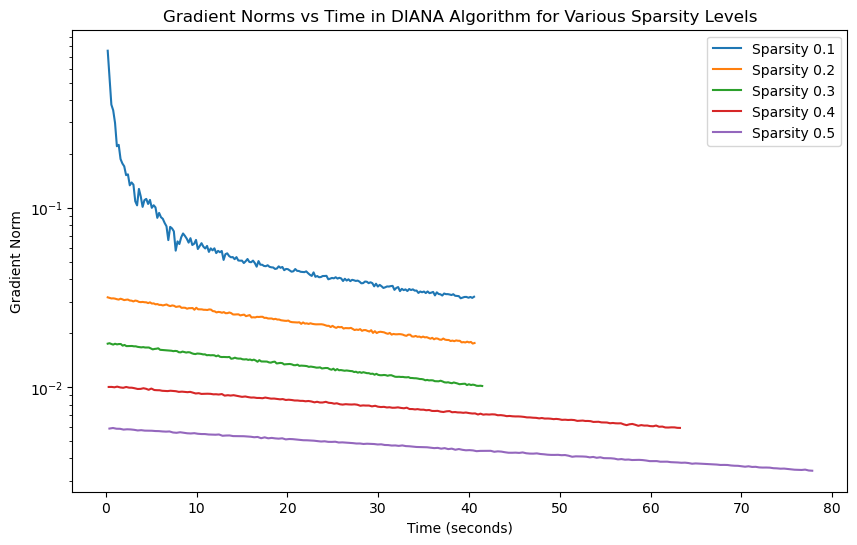

In [9]:
# Parameters
n_workers = 12
x_0 = np.copy(w_initial)
h_i_0 = [np.copy(w_initial) for _ in range(n_workers)]
h_0 = np.mean(h_i_0, axis=0)
alpha = 1/10
gamma = 0.5
K = 200
h_i_k = list(h_i_0)

# Different sparsity levels to test
sparsity_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

# Run the simulation for each sparsity level and plot results
plt.figure(figsize=(10, 6))
for sparsity_level in sparsity_levels:
    _, times, grad_norms = diana_simulation(nabla_f, x_0, h_i_0, h_0, alpha, gamma, n_workers, K, sparsity_level)
    cumulative_times = np.cumsum(times)
    plt.plot(cumulative_times, grad_norms, label=f"Sparsity {sparsity_level}")

plt.yscale('log')
plt.xlabel("Time (seconds)")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norms vs Time in DIANA Algorithm for Various Sparsity Levels")
plt.legend()
plt.show()

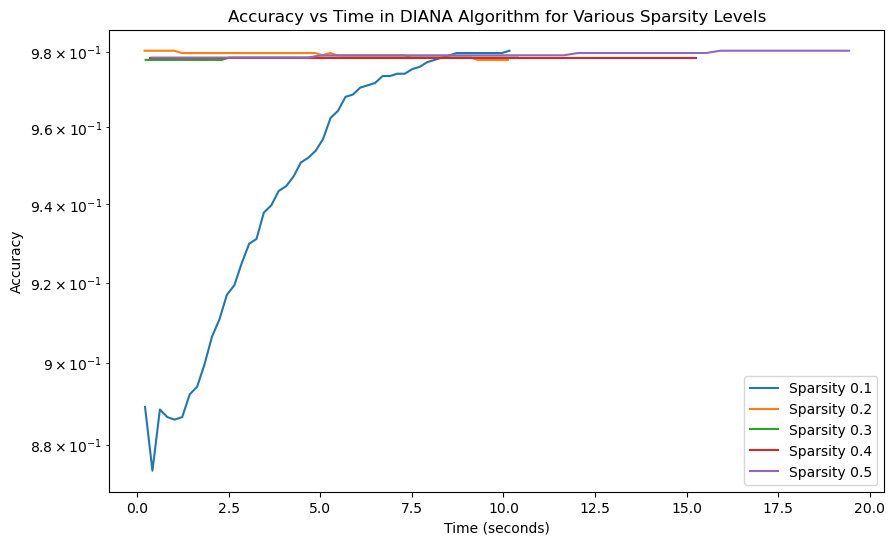

In [10]:
# DIANA simulation parameters
n_workers = 12
x_0 = np.copy(w_initial)
h_i_0 = [np.copy(w_initial) for _ in range(n_workers)]
h_0 = np.mean(h_i_0, axis=0)
alpha = 1/20
gamma = 0.5
K = 50
h_i_k = list(h_i_0)
sparsity_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

def calculate_accuracies(x_star, X_test, y_test):
    accuracies = []
    for w in x_star:
        predictions = predict(w, X_test)
        predicted_labels = np.where(predictions >= 0, 1, -1)
        accuracy = np.mean(predicted_labels == y_test)
        accuracies.append(accuracy)
    return accuracies

# Plot accuracies for each sparsity level
plt.figure(figsize=(10, 6))
for sparsity_level in sparsity_levels:
    x_star, times, _ = diana_simulation(nabla_f, x_0, h_i_0, h_0, alpha, gamma, n_workers, K, sparsity_level)
    accuracies = calculate_accuracies(x_star, X_test, y_test)
    cumulative_times = np.cumsum(times)
    plt.plot(cumulative_times, accuracies, label=f"Sparsity {sparsity_level}")

plt.yscale('log')
plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Time in DIANA Algorithm for Various Sparsity Levels")
plt.legend()
plt.show()

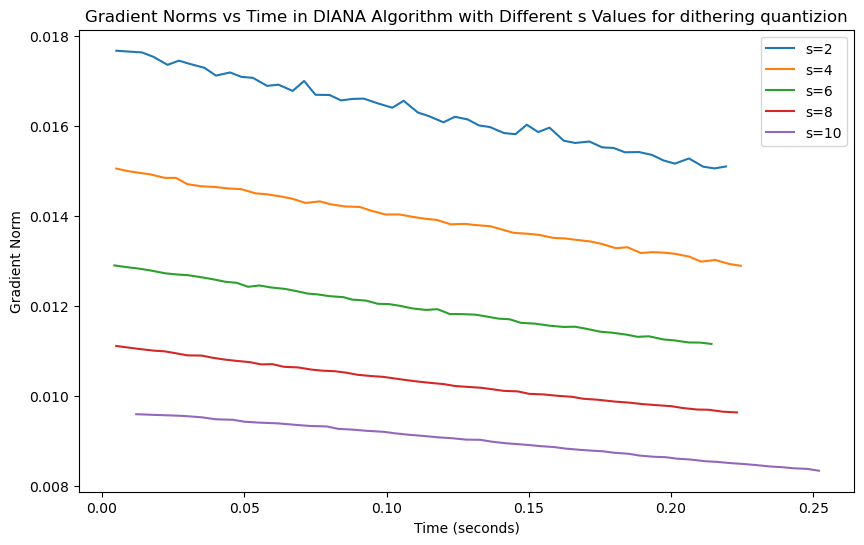

In [11]:
def Q(x, s):
    """
    Quantizes the input vector x using the given sparsity level s.
    
    Args:
    x (np.array): The input vector to be quantized.
    s (float): The sparsity level for quantization.

    Returns:
    np.array: The quantized vector.
    """
    # Compute the sign of x
    sign_x = np.sign(x)
    
    # Compute the l_p norm of x
    l_p_norm = np.linalg.norm(x)  # Using L2 norm as an example (p=2)
    
    # Compute the stochastic rounding term
    xi = np.random.uniform(0, 1, size=x.shape)  # Uniformly distributed noise
    stochastic_rounding = np.floor(np.abs(x) / l_p_norm * s + xi)
    
    # Quantize x
    quantized_x = sign_x * l_p_norm / s * stochastic_rounding
    
    return quantized_x


def worker_update2(i, x_k, nabla_f, s):
    global h_i_k, alpha
    
    g_i_k = nabla_f(x_k, i)
    delta_i_k = g_i_k - h_i_k[i]
    quantized_delta_i_k = Q(delta_i_k, s)
    h_i_k[i] = h_i_k[i] + alpha * quantized_delta_i_k
    return quantized_delta_i_k

def diana_simulation(nabla_f, x_0, h_i_0, h_0, alpha, gamma, n_workers, K, s):
    x_values = []
    times = []
    x_k = x_0
    h_k = h_0
    gradient_norms = []
    for k in range(K):
        iteration_start = time.time()
        
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            futures = [executor.submit(worker_update2, i, x_k, nabla_f, s) for i in range(n_workers)]
            results = [future.result() for future in futures]
        
        delta_k_hat = np.mean(results, axis=0)
        g_k_hat = h_k + delta_k_hat
        x_k -= gamma * g_k_hat
        h_k += alpha * delta_k_hat
        
        x_values.append(np.copy(x_k))
        gradient_norms.append(np.linalg.norm(g_k_hat))
        times.append(time.time() - iteration_start)

    return x_values, times, gradient_norms

# Now let's run the simulation with different sparsity levels and plot the results.
sparsity_levels = [2, 4, 6, 8, 10]  # Different s values to simulate
results = {}

for s in sparsity_levels:
    x_star, times, grad_norms = diana_simulation(nabla_f, x_0, h_i_0, h_0, alpha, gamma, n_workers, K, s)
    results[s] = (x_star, times, grad_norms)

# Plot the results
plt.figure(figsize=(10, 6))
for s, (x_star, times, grad_norms) in results.items():
    cumulative_times = np.cumsum(times)
    plt.plot(cumulative_times, grad_norms, label=f"s={s}")

plt.xlabel("Time (seconds)")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norms vs Time in DIANA Algorithm with Different s Values for dithering quantizion")
plt.legend()
plt.show()

In [12]:
compressed_data

NameError: name 'compressed_data' is not defined

In [ ]:
w_initial